# Reviewing Jupyter Widgets: Building Widgets for our Data Dashboard

In [1]:
# Import exception handling
import dashboard

### Goal of this Notebook

In this notebook we will be developing a `widgets.py` mofile which will allow use to build widgets for our data dashboard that build GUI controls for our [previous data workflow](./01b_workflow.ipynb). 
We will learn how to...

### Steps You Will Take In This Notebook
In this notebook you will:
1. Briefly review ipywidgets.
2. Load data from a file.
3. Review the role of traits and how they can be used to create interactivity with widgets.
4. Create an interactive slider widget to select and display selected range of years.  To do this we must:
    - Use the slider value to update the `selected` data.
    - Update the `selected` data *every time* the range is modified.
    - Create a pandas dataframe representing the new time range.
5. Create some widgets to control the smoothing/filtering of the temperature data.  To do this we must:
    - Create a slider widget to select the window size (aka the number of adjacent data points) to use for the smoothed/filtered data.
    - Create an integer input widget to select the degree of the polynomial fit for the smoothed/filtered data.
    - Update the smoothed/filtered data in the pandas dataframe.
6. Use output widgets to display both the raw data and a plot.  Both should be updated when year range or smoothing/filtering parameters are changed.

## Building the Widgets Module of our Package

We will be developing the `widgets.py` module in this notebook, so we start by declaring that module to be our intended export target in `nbdev`. Notice that as we work through this notebook, we will export only those cells necessary to create the `widgets.py` module, leaving other cells which provide examples our testing or development process intact.

In [2]:
#| default_exp widgets

## Preview the Final Product

We will be converting our previous data workflow into a fully interactive web-based dashboard using Jupyter widgets.  The final product will look something like this:

![Preview Image of Data Dashboard](static/dashboard_screenshot.png)

## Reviewing Jupyter Widgets

Let's add an import statement for Jupyter widgets (aka `ipywidgets`). We will use a lot of widgets, so it's good to `import ipywidgets as widgets`, or something similarly short. 

**EXERCISE**: Add an import statement below:

In [6]:
#| export
# %answer key/dashboard/widgets.py 7

import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
# add import statement for Jupyter widgets
import ipywidgets as widgets

The package `ipywidgets` provides two things:

+ A communication framework between the front end (your browser) and back end (Python or other kernel).
+ A set of fundamental user interface elements like buttons and checkboxes.

Execute the next cell to create a browser of the available elements. To see some example code for implementing any of the elements click on its title. It will be easier to view both this overview and [the code examples](reference/complete-ipywidgets-widget-list.ipynb) if you have them open in separate tabs.

Additional Resources:
- [nicole-brewer/awesome-jupyter-widgets](https://github.com/nicole-brewer/awesome-jupyter-widgets) lists many packages taking advantage of Jupyter widgets
- [Jupyter widgets documentation site](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html).

In [7]:
from static.widget_org import organized_widgets, list_overview_widget

groups = organized_widgets(organize_by='ui')
help_url_base='static/complete-ipywidgets-widget-list.ipynb'
list_overview_widget(groups, columns=2, min_width_single_widget=200, help_url_base=help_url_base)

## Load Data from File

Now we will create a cell to load the data into a pandas dataframe, just [like last time](./01b_workflow.ipynb).  We will export this since we will need this for our dashboard.

In [8]:
#| export
# Load data into memory from file
DATA_DIR = 'data'
DATA_FILE = 'land-ocean-temp-index.csv'

original_df = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE), escapechar='#')

In [9]:
# Display the original data
original_df

,Year,Temperature
0,1880,-0.16
1,1881,-0.08
2,1882,-0.11
3,1883,-0.17
4,1884,-0.28
...,...,...
139,2019,0.98
140,2020,1.02
141,2021,0.85
142,2022,0.90


## Our First Widget: `IntRangeSlider`

We want to select the range of years of temperature data to display interactively via the dashboard.

To do this, we will implement our first widget. Because we are selecting a range of years, we will use the `IntRangeSlider` widget, which has two click and drag nobs.

Let's see what how to create the `IntRangeSlider` widget:

In [10]:
#| export
year_range = widgets.IntRangeSlider(description = 'Range of Years',
                                    style={'description_width': 'initial'})
# The style argument is used to set the width of the description wide enough
# to display the entire text

{'name': '_property_lock', 'old': {}, 'new': {'value': [1880, 2002]}, 'owner': IntRangeSlider(value=(1880, 2002), description='Range of Years', max=2023, min=1880, style=SliderStyle(description_width='initial')), 'type': 'change'}
{'name': '_property_lock', 'old': {'value': [1880, 2002]}, 'new': {}, 'owner': IntRangeSlider(value=(1880, 2002), description='Range of Years', max=2023, min=1880, style=SliderStyle(description_width='initial')), 'type': 'change'}
{'name': '_property_lock', 'old': {}, 'new': {'value': [1990, 1993]}, 'owner': IntRangeSlider(value=(1990, 1993), description='Range of Years', max=2023, min=1880, style=SliderStyle(description_width='initial')), 'type': 'change'}
{'name': '_property_lock', 'old': {'value': [1990, 1993]}, 'new': {}, 'owner': IntRangeSlider(value=(1990, 1993), description='Range of Years', max=2023, min=1880, style=SliderStyle(description_width='initial')), 'type': 'change'}


In [11]:
# Display the widget
year_range

IntRangeSlider(value=(25, 75), description='Range of Years', style=SliderStyle(description_width='initial'))

Okay great! But 0 - 100 isn't the range we want. Instead, we would like the minimum and maximum to be the earliest and latest years in our dataset. So we need to obtain those first.

In [12]:
(min(original_df['Year']), max(original_df['Year']))

(1880, 2023)

### Setting Slider Limits

Widgets, like other Python objects, have attributes. Recall that to set the value of an attribute of an object, we use 'dot notation' (e.g. `box.width `sets the `width` attribute of object `box`).

**EXERCISE**: Set the `min` and `max` attributes of the slider widget.  Then look back at the `year_range` widget above.

In [16]:
#| export
# %answer key/dashboard/widgets.py 20

# set the 'max' attribute of the slider to the maximum year of the our data
# and let's do the same for 'min'

year_range.max = max(original_df['Year'])
year_range.min = min(original_df['Year'])

Now go up and look at the slider widget...

Okay that looks a lot better, but how to we actually get the value of the range from the widget? Generally, most widgets have a `value` attribute, but since there are actually two values in a range, I'm not sure what to expect. Let's see what happens when we try and poll the value attribute. What data type is it?

In [17]:
year_range.value

(1880, 2023)

That looks like a tuple. Let's try setting the value programmatically as well and look back at the slider widget.

In [18]:
year_range.value = (1900, 2000)

Okay, now that we can get the range from the slider, how do we relect those selections back to the dataframe? 

## Use the slider value to update the `selected_df` data
Well, we probably want to keep two copies, because if we change the original to have a shorter range, and then we want to expand that range, we're going to have lost data. So let's maintain a dataframe called `selected_df` that reflects the range specified by the Slider. Let's look at how we did that in workflow.ipynb. 

```python
selected_df = original_df[(original_df['Year'] >= from_year) & (original_df['Year'] <= to_year)]
```
The only difference is this time, we need to replace "from_year" and "to_year" with the value of our slider.

**EXERCISE**:  Update the `selected_df` dataframe to reflect the range specified by the slider.  You can test if your solution works by executing the next cell and then running the cell below it.

In [19]:
#| export
# %answer key/dashboard/widgets.py 26

from_year, to_year = year_range.value

selected_df = original_df[(original_df['Year'] >= from_year)
                          & (original_df['Year'] <= to_year)]

Display the `selected_df` dataframe to make sure it worked.

In [20]:
selected_df

,Year,Temperature
20,1900,-0.09
21,1901,-0.16
22,1902,-0.28
23,1903,-0.37
24,1904,-0.48
...,...,...
116,1996,0.33
117,1997,0.46
118,1998,0.61
119,1999,0.38


Okay, that's a start. But now we want to do this dynamically. That is, we want the line above to be called every time the range is modified. 

## Update the `selected_df` data *every time* the range is modified

How do we track changes to the value of the slider?

### Observing trait changes

Widgets are built on the `traitlets` library, which we will learn more about later on. Attributes of objects that inherit the `HasTraits` class, such as widgets do, are called **traits**.  Jupyter widgets have an `observe` method that lets you register a handler function that is called when a trait changes.

In [21]:
# Create a function that will print the change event
def on_range_change(change):
    print(change)

In [22]:
# Attach the above 'handler' function to the widget so that it gets called whenever a
# trait of the widget changes.
year_range.observe(on_range_change) # Warning: This is actually a poor practice, see below...

So if we change the value of the slider, our handler function (`on_range_change`) will print the variable `change`. Apparently the `observe` method of a widget passes some variable to the handler function (the variable we are assigning the name `change`).

But what is contained in `change`? Let's find out by changing the value of the slider programmatically and thus triggering the handler function..

In [23]:
year_range.value = (1880, 2002)

{'name': 'value', 'old': (1900, 2000), 'new': (1880, 2002), 'owner': IntRangeSlider(value=(1880, 2002), description='Range of Years', max=2023, min=1880, style=SliderStyle(description_width='initial')), 'type': 'change'}


It's clear that `change` is a dictionary. There are a lot of key/value pairs here, but the most important ones for us right now are the `old` and `new` keys. We can use their associated values to see what the widget's traits used to be, and what they were updated to.

## Update `selected_df` dataframe with new range
Now that we know how to observe changes in the slider value, we want to use that `observe` method to update the `selected_df` dataframe. Let's rewrite the `on_range_change` function so that it updates the `selected_df` dataframe.

In [24]:
#| export

# Create a function that will change the selected_df based on the range of
# years selected by the user using the year_range widget
def on_range_change(change):
    global selected_df
    selected_df = original_df[(original_df['Year'] >= change['new'][0])
                              & (original_df['Year'] <= change['new'][1])]
    # WARNING: You could have thought to use:
    #  selected_df = original_df[(original_df['Year'] >= year_range.value[0])
    #                             & (original_df['Year'] <= year_range.value[1])]
    # but for many manual interactions, such as a click and drag slider, a high
    # overturn of quickly changing widget values could silently cause
    # unexpected behavior in changing values, so that syntax should be avoided

And now let's test it by directing the `observe` method to call this new `on_range_change` every time the value of the slider changes. 

While we do this, let's address a poor Jupyter widget programming practice we showed earlier.  There is an optional second argument to the `observe` method which is the name of the trait to watch for changes.  We didn't include it... this is not a good choice.

While the name of the trait to watch is technically optional, you really should always include it.  Why?  It has a default value of 'All' which watches all traits. This includes traits that start with an underscore (i.e. traits meant by the programmer to be private).  Furthermore, if too many changes occur at once, there is a chance your function will be called on a change to one of these internal traits - such as '_property_lock' - and cause your callback to fail or even silently cause unexpected behavior.

So a good Jupyter widgets programmer should always specify the trait we are observing for changes, which is normally 'value'.

In [25]:
# Connect the new version of the handler function to the widget via observe
# method, this time providing the name of the trait to watch.
year_range.observe(on_range_change, 'value')

In [26]:
# Programmatically set the value of the widget
year_range.value = (1990, 1993)

# Confirm the selected dataframe changed
selected_df

{'name': 'value', 'old': (1880, 2002), 'new': (1990, 1993), 'owner': IntRangeSlider(value=(1990, 1993), description='Range of Years', max=2023, min=1880, style=SliderStyle(description_width='initial')), 'type': 'change'}


,Year,Temperature
110,1990,0.45
111,1991,0.40
112,1992,0.22
113,1993,0.23


That worked really well! But we are still printing the value of `change`. I thought we redefined the function!

As it turns out, both versions of the function have copies that are called when there is a change in `year_range`.  This is an illustration that we can attach MULTIPLE handler functions to a single widget.  That said, it is a bit confusing to have two functions with the same name attached to this widget.

**Note**: This happened because functions are immutable objects in Python, so when we redefined the function, we were actually creating a new function object and assigning it to the same name.  The old function object was still attached to the widget.

### Unobserve trait changes

To get rid of all those observe functions, we use the `unobserve_all` method. Go ahead and try that.

In [27]:
year_range.unobserve_all()

In [28]:
%%exception

year_range.observe()
year_range.value = (1987, 1991)

TypeError: HasTraits.observe() missing 1 required positional argument: 'handler'

**EXERCISE**: Notice the previous cell returned an exception. Sort of a weird one. We are missing something on our `observe` call. Can you think of what it is? Go ahead and make the changes needed below.

In [46]:
year_range.unobserve_all()

In [47]:
#| export
# %answer key/dashboard/widgets.py 46

year_range.observe(on_range_change, 'value')

In [48]:
# Adjust the range of years and confirm the selected dataframe changed
year_range.value = (1900, 2000)

selected_df

,Year,Temperature
20,1900,-0.09
21,1901,-0.16
22,1902,-0.28
23,1903,-0.37
24,1904,-0.48
...,...,...
116,1996,0.33
117,1997,0.46
118,1998,0.61
119,1999,0.38


Does it run like it's supposed to now? Great! Now that we have that down, the next step is to update the dataframe display every time the range is changed. But how do we achieve that? The dataframe isn't actually a widget yet. It's just being displayed with ipython. But we can turn anything that can be displayed with ipython into a widget with Output.

## Output widgets

First, let's see what output looks like on it's own.

In [49]:
# Create an Output widget to display the selected data
selected_dataframe_view = widgets.Output()

In [50]:
# Display the Output widget
selected_dataframe_view

Output()

Pretty boring. **Let's right click on the Output widget and "Create new view for output"** for now. How do we get it to display our dataframe? We use the Output widget as a context manager. Anything that we can display with ipython.display can be displayed by the Output widget using the following syntax.

In [51]:
selected_dataframe_view.clear_output()
with selected_dataframe_view:
    display(original_df)

Voila! The `selected_dataframe_view` widget now displays the original dataframe (notice it contains years 1880 to 2023). 

Now we need to be able to update that display when someone changes the year range (i.e. displaying the `selected_df` dataframe which it changes in response to a `year_range` change). Let's write a handler function for this.

In [52]:
# Create a handler function that will display the selected dataframe
def output_selected_dataframe(change):
    selected_dataframe_view.clear_output(wait=True)
    with selected_dataframe_view:
        display(selected_df)

# Call the function (since called outside observe method, use None as argument)
output_selected_dataframe(None)

Cool! Now the only thing that is missing is that we want to call this function every time the range is updated. How might we go about that?

Let's connect the `output_selected_dataframe` function to the `year_range` widget with the `observe` method.

In [53]:
year_range.observe(output_selected_dataframe, 'value')

Okay let's create another copy of the slider so we can change the value. Then go ahead and move the range around and see if you notice changes to the displayed dataframe above.

In [54]:
year_range

IntRangeSlider(value=(1900, 2000), description='Range of Years', max=2023, min=1880, style=SliderStyle(descrip…

Way cool. Now our dataframe reflects the range of values.

### A Better Way to Display Dataframes

Notice that the size of the displayed pandas dataframe changes because default display of a dataframe is to only show up to 30 rows. This means our Output widget changes size when we change the range of years in the selected data.

Another approach is rather than using the generic output widget to instead use one that is specifically designed for pandas dataframes. It's called [ipydatagrid](https://github.com/bloomberg/ipydatagrid). Let's import it and see how it works.

In [55]:
#| export
from ipydatagrid import DataGrid

# Define a DataGrid widget containing our Pandas dataframe setting column and row sizes
selected_data_grid = DataGrid(selected_df, header_visibility="column", auto_fit_columns=True)

And let's view our selected dataframe in this widget

In [56]:
# Display the DataGrid widget here
selected_data_grid

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

In [57]:
# Create a handler function that will display the selected dataframe
def output_selected_dataframe(change):
    selected_dataframe_view.clear_output(wait=True)
    with selected_dataframe_view:
        display(selected_data_grid)

# Call the function (since called outside observe method, use None as argument)
output_selected_dataframe(None)

Notice that the `DataGrid` widget includes some nice features such as auto-fitting the column and row size and choosing to only show the column headers (which hides the 'index' at the beginning of each row of a `pandas` dataframe).  We can also resort data in the visual display of the table via drop downs. But its biggest advantage is that it doesn't change size when the number of rows changes, instead a scrollbar appears or disappears as needed.

It is a widget which means we can define a function to update the data displayed in the widget.  Let's try that below.

In [58]:
#| export
# Create a handler function that will display the selected dataframe
def update_selected_datagrid(change):
    selected_data_grid.data = selected_df

# Attach the handler function to the year_range widget
year_range.observe(update_selected_datagrid, 'value')

Let's create yet another copy of the `year_range` slider and see how changing it affects the datagrid widget we created above.

In [59]:
year_range

IntRangeSlider(value=(1900, 2000), description='Range of Years', max=2023, min=1880, style=SliderStyle(descrip…

## Add column for Smoothed Data

Now we have data selection down, so the next step is to also add a column to our data for the smoothed data curve. Rather than plotting two different smoothed curves as we did in [our original data workflow](./01b_workflow.ipynb), we will only plot one, but we will allow the user to change the degree of the polynomial fit and the window size of the filter.

In [103]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size_int = 20
poly_order_int = 3

# Apply Savitzky-Golay smoothing to the Temperature column
original_df['Smoothed Data'] = savgol_filter(original_df['Temperature'],
                                             window_size_int, 
                                             poly_order_int).round(decimals=3)

# Display the pandas DataFrame with the new column
original_df

,Year,Temperature,Smoothed Data
0,1880,-0.16,-0.091
1,1881,-0.08,-0.139
2,1882,-0.11,-0.178
3,1883,-0.17,-0.210
4,1884,-0.28,-0.235
...,...,...,...
139,2019,0.98,0.947
140,2020,1.02,0.975
141,2021,0.85,0.999
142,2022,0.90,1.020


Okay. So we have these two variables that we want to control via widgets. We want to use a slider for the window size and an integer input for the degree of the polynomial fit. Let's start with the slider.

In [104]:
#| export
window_size = widgets.IntSlider(description = 'Window Size', value=20, min=2, max=100,
                                style={'description_width': 'initial'})

In [105]:
window_size

IntSlider(value=20, description='Window Size', min=2, style=SliderStyle(description_width='initial'))

For the Polynomial order, we will use an integer text field input that is bounded between 1 and 10.

In [115]:
#| export
poly_order = widgets.BoundedIntText(description = 'Poly Order', min=1, value=3, max=10,
                                    style={'description_width': 'initial'})

In [107]:
poly_order

BoundedIntText(value=3, description='Poly Order', max=10, min=1, style=DescriptionStyle(description_width='ini…

Now when we update window size, we want a few things to happen.

1. Update `original_df` with the new smoothed data column.  Remember to use windowsize and polynomial degree from the widgets.
2. Use `original_df` to update selected
3. Update Datagrid display of `selected_df`

**EXERCISE**: Modify the function in the next cell so that it takes care of the first two items listed above.  Replace the comments in the `on_window_size_change` function in the cell below with the correct lines to accomplish those functions.

In [108]:
# %answer key/02b/01.py

def on_window_size_change(change):
    global original_df, selected_df # Remember to access the global variables
    # Update the following call to update the original_df['Smoothed Data'] column
    # values to properly capture the change in window_size value and the
    # current poly_order value.
    original_df['Smoothed Data'] = savgol_filter(original_df['Temperature'],
                                                 change['new'],
                                                 poly_order.value).round(decimals=3)
    selected_df = original_df[(original_df['Year'] >= year_range.value[0])
                              & (original_df['Year'] <= year_range.value[1])]

Then do you recall what function we used to display the dataframe? It was `update_selected_datagrid`. 

Let's update add both of these handler functions (`on_window_size_change` and `update_selected_datagrid`) as a handler function for the `observe` method of `window_size`.

In [109]:
window_size.observe(on_window_size_change, 'value')
window_size.observe(update_selected_datagrid, 'value')

In [110]:
selected_data_grid

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

In [111]:
window_size

IntSlider(value=20, description='Window Size', min=2, style=SliderStyle(description_width='initial'))

Sweet! If you increase the value of `window_size` you will see that there is now a "Smoothed Data"" column.

**EXERCISE**: Now create a Slider widget that is linked to the `poly_order`.

In [120]:
#| export
# %answer key/dashboard/widgets.py 85

def on_poly_order_change(change):
    global original_df, selected_df
    # Change the following line that sets the 'Smoothed Data' column of original_df
    # to catch the change in poly_order widget value and update the original_df for it.
    # Remember to also catch the current window_size value.
    original_df['Smoothed Data'] = savgol_filter(original_df['Temperature'],
                                                 window_size.value,
                                                 change['new']).round(decimals=3)
    selected_df = original_df[(original_df['Year'] >= year_range.value[0])
                              & (original_df['Year'] <= year_range.value[1])]

In [121]:
#| export
poly_order.observe(on_poly_order_change, 'value')
poly_order.observe(update_selected_datagrid, 'value')

In [122]:
poly_order

BoundedIntText(value=5, description='Poly Order', max=10, min=1, style=DescriptionStyle(description_width='ini…

That looks pretty good! Let's try setting both values programmatically.

In [123]:
%%exception

window_size.value = 3
poly_order.value = 5

ValueError: polyorder must be less than window_length.

Oh oh! Why did this happen? Fortunately the error message is pretty clear. We need to ensure that our `poly_order` Slider doesn't allow a user to select a value greater than `window_size - 1`. But we also don't want to let `poly_order` be greater than 10 to avoid poor conditioning. Where should we put this validation? 

**EXERCISE**: Update the "max" trait of `poly_order` every time `window_size` is updated. So we need to add a line to add a line in the `on_window_size_change` function.

In [125]:
#| export
# %answer key/dashboard/widgets.py 91

def on_window_size_change(change):
    global original_data, selected_df, poly_order
    # change the maximum of the poly_order widget
    # catch the change in the window_size widget value and update the original_df
    poly_order.max = min(10, change['new'] - 1)
    original_df['Smoothed Data'] = savgol_filter(original_df['Temperature'],
                                                 change['new'],
                                                 poly_order.value).round(decimals=3)
    selected_df = original_df[(original_df['Year'] >= year_range.value[0])
                              & (original_df['Year'] <= year_range.value[1])]


In [126]:
window_size.unobserve_all()

In [127]:
#| export
window_size.observe(on_window_size_change, 'value')
window_size.observe(update_selected_datagrid, 'value')

In [128]:
window_size

IntSlider(value=3, description='Window Size', min=2, style=SliderStyle(description_width='initial'))

In [129]:
poly_order

BoundedIntText(value=8, description='Poly Order', max=10, min=1, style=DescriptionStyle(description_width='ini…

Export default values that will be used to perform a running average for the smoothing initially.

In [130]:
#| export
window_size.value = 10
poly_order.value = 1

Amazing! We are done visualizing our selected data. Now we can move on to visualizing our data with a plot.

## Visualizing Data

We will use [matplotlib](https://matplotlib.org), because the syntax is so common, but there are more interactive widgets in the ipywidget ecosystem that would work even better, such as [bqplot](https://bqplot.github.io/bqplot/).

Before we get started, let's take a look at what we had in the original workflow.

```python
plt.xlabel('Year')
plt.ylabel('Temperature Anomalies over Land w.r.t. 1951-80 (˚C)')
plt.title('Global Annual Mean Surface Air Temperature Change')
plt.plot(subset_df['Year'], subset_df['Temperature'], label='Raw Data')
plt.plot(subset_df['Year'], subset_df[SG_col], label='Smoothed Data')
plt.legend()
plt.show()
```

**EXERCISE** We are going to want to turn set of commands into a handler function that accepts a "change" parameter and draws the plot. Is there anything we need to fix here to make this work? It's very minor. Replace the commented code in the cell below with functional code so that it works in our current notebook.

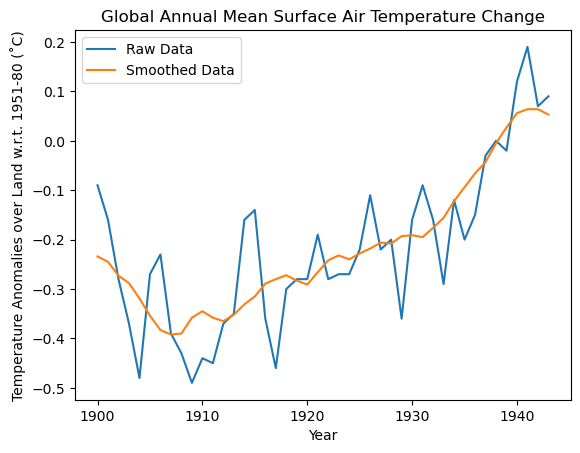

In [136]:
# %answer key/02b/02.py

plt.xlabel('Year')
plt.ylabel('Temperature Anomalies over Land w.r.t. 1951-80 (˚C)')
plt.title('Global Annual Mean Surface Air Temperature Change')
plt.plot(selected_df['Year'], selected_df['Temperature'], label='Raw Data')
plt.plot(selected_df['Year'], selected_df['Smoothed Data'], label='Smoothed Data')
plt.legend()
plt.show()


Okay that works, but the plot is showing up inline in our notebook. Once created, it can't be modified except by changing the data and re-executing the cell.  It sure would be nice if we could have the plot automatically update when the data year range or smoothing parameters are changed.  How do we do that?

Yeah, we can use an Output widget again, just like we did with the dataframe.

**EXERCISE** Create a `plot_view` output widget (you don't need to display it as it will be initially empty, although you certainly can if you want to test it).

In [144]:
#| export
# %answer key/dashboard/widgets.py 101

plot_view = widgets.Output() # create an output widget called plot_view

If we call the `plot_view` Output widget, it would currently be blank.  Let's fix this by creating a function that will update the `plot_view` Output widget display. Recall that to update a Output widget (it was `selected_dataframe_view`) we created a function that would update it by calling `display` with the content to show in that Output widget:
```python
def output_selected_dataframe(change):
    selected_dataframe_view.clear_output(wait=True)
    with selected_dataframe_view:
        display(selected_df)
```

**EXERCISE** Go ahead and adapt this approach in the cell below so that instead of displaying the selected dataframe, the function displays an updated plot.

In [145]:
#| export
# %answer key/dashboard/widgets.py 103

def output_plot(change):
    plot_view.clear_output(wait=True)
    with plot_view:  # Add with content handler for `plot_view`
        plt.xlabel('Year')
        plt.ylabel('Temperature Anomalies over Land w.r.t. 1951-80 (˚C)')
        plt.title('Global Annual Mean Surface Air Temperature Change')
        plt.plot(selected_df['Year'], selected_df['Temperature'], label='Raw Data')
        plt.plot(selected_df['Year'], selected_df['Smoothed Data'], label='Smoothed Data')
        plt.legend()
        plt.show()

Let's make sure our new callback works when we call it explicitly. If we display `plot_view` again, we shouldn't see any output initially.

In [146]:
# Display plot_view again
plot_view

Output()

In [147]:
# Call the output_plot function to test output_plot function works.
# Use None as argument (since this function is expecting a change variable as argument).
output_plot(None)

Now let's make sure this function gets called any time there is a change to our selected data or to the Savitzky-Golay parameters. How do we make sure this function runs every time there is a change?

In [148]:
#| export
year_range.observe(output_plot, 'value')
window_size.observe(output_plot, 'value')
poly_order.observe(output_plot, 'value')

Let's set the initial year range to use for selected data to be 1900-2000.

In [149]:
#| export
year_range.value = (1900, 2000)

Now let's create copies of the sliders and see if the above plot responds to changes in the sliders.

In [150]:
year_range

IntRangeSlider(value=(1900, 2000), description='Range of Years', max=2023, min=1880, style=SliderStyle(descrip…

In [151]:
window_size

IntSlider(value=10, description='Window Size', min=2, style=SliderStyle(description_width='initial'))

In [152]:
poly_order

BoundedIntText(value=1, description='Poly Order', max=9, min=1, style=DescriptionStyle(description_width='init…

Wow that looks amazing! We have a total of five widgets. Three of them control various parameters and they have dependencies on each other. In the next notebook, we will see how this can all come together into one very beautiful interface.

In [1]:
from nbdev.export import nb_export
nb_export('02b_widgets.ipynb', 'dashboard')